In [4]:
from gridworld import *
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential;
from keras.layers import Dense, Activation;
from keras import initializers;
from keras.optimizers import Adam, SGD;
from keras import backend as K
import pandas as pd
from tqdm import tqdm, trange
%matplotlib inline
#Deep Q-Learning

#gw = gridworld((5, 5), (0, 0), (4, 0), [(o, 0) for o in range(4)], 0.9, 0, 1, 0)
gw = gridworld((5, 5), (0, 0), (4, 0), [(o, 0) for o in range(1, 4)], 0.9, 0, 1, 0)
# Discount Rate
gamma = 0.95

In [5]:
def loss(Qtarget, Q):
    return K.sum(K.square(Qtarget - Q))

def state_tup_to_num(state_tup):
	state_num = state_tup[0]*gw.M + state_tup[1]
	return state_num

def state_num_to_tup(state_num):
	state_tup = (state_num/gw.M, state_num%gw.M)
	return state_tup

# Chance of random action
e = 0.1
learning_rate = 0.01
# Training Episodes
episodes = 1000
# Max Steps per episode
steps = 50
trials = 1

100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


Successful episodes: 0.644


<Figure size 648x1152 with 0 Axes>

Text(0.5,1,'Step Moving Average (100-episode window)')

Text(0,0.5,'Moves')

Text(0.5,0,'Episode')

Text(0.5,1,'Reward Moving Average (100-episode window)')

Text(0,0.5,'Reward')

Text(0.5,0,'Episode')

Text(0.5,1,'Loss Moving Average (100-episode window)')

Text(0,0.5,'Loss')

Text(0.5,0,'Episode')

Text(0.5,1,'Random Action Parameter')

Text(0,0.5,'Chance Random Action')

Text(0.5,0,'Episode')

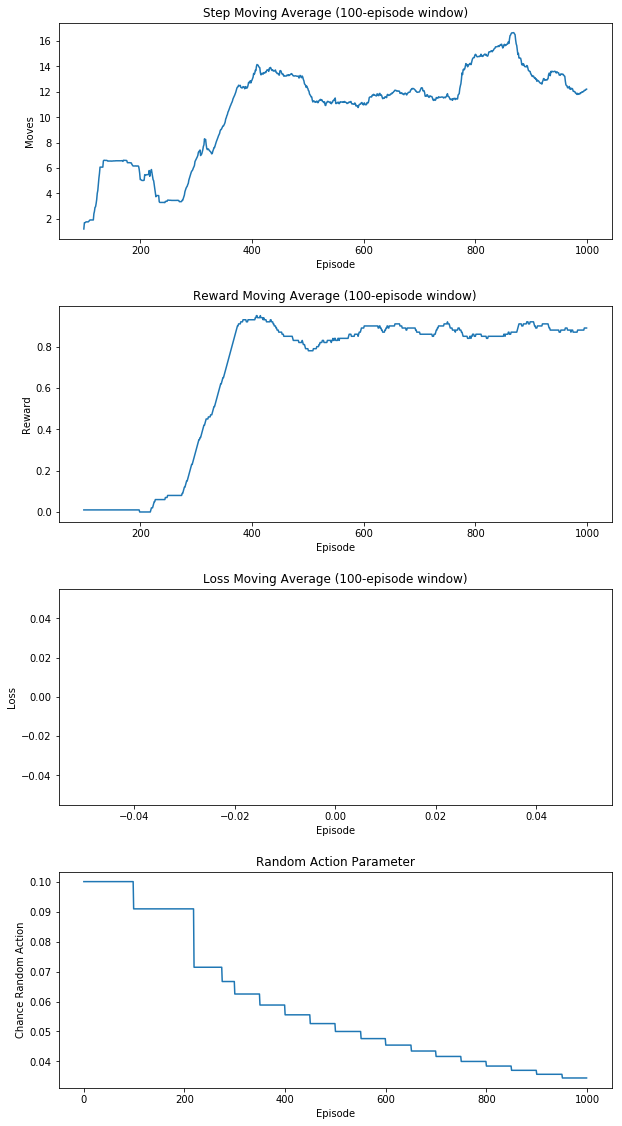

Score over time: 0
Final Q-Table Values


,0,1,2,3,4
0,0.64,0.70,0.72,0.72,0.66
1,E,0.61,0.73,0.74,0.75
2,E,0.66,0.80,0.80,0.80
3,E,0.72,0.79,0.91,0.87
4,G,1.05,1.02,0.96,0.89


,0,1,2,3,4
0,➡,➡,➡,⬇,⬇
1,E,➡,➡,⬇,⬇
2,E,➡,➡,⬇,⬅
3,E,⬆,➡,⬇,⬅
4,G,⬅,⬅,⬅,⬅


In [6]:
Qt_list = []
rt_list = []

for t in range(trials):

    # Initialize history memory
    step_list = []
    reward_list = []
    loss_list = []
    e_list = []

    #Model
    initializer = initializers.random_uniform(0, 0.1, seed=1)
    model = Sequential([Dense(4, input_dim=gw.M*gw.N, 
                        kernel_initializer=initializer,
                        use_bias=False
                                 )])
    model.compile(loss=loss, optimizer=Adam(lr=learning_rate))


    #Transform into one-hot vector
    def OH(l, x):
        return np.identity(l)[x].reshape(1,l)


    for i in trange(episodes):
        # Initialize
        state = gw.reset()
        reward_all = 0 #Reward counter
        done = False
        s = 0 #Step counter
        l = 0 #Loss

        for s in range(steps):
            # Choose action randomly or through agent model
            Q = model.predict(OH(gw.M*gw.N, state_tup_to_num(state)), batch_size=1)
            if np.random.rand(1) < e:
                action = np.random.choice([0,1,2,3])
            else:
                action = np.argmax(Q)

            # Take action and obtain new state and reward    
            new_state, reward, done = gw.step(action)

            # Adjust reward if done without reaching end
            #if done and reward == 0.0: reward = -1

            # Find max-Q for future state
            Q1 = model.predict(OH(gw.M*gw.N, state_tup_to_num(new_state)), batch_size=1)
            maxQ1 = np.max(Q1)

            # Bellman Equation
            # Update target for training by adding reward for action and discounted max next state Q-value
            targetQ = Q
            targetQ[0, action] = reward + (gamma * maxQ1)
    #         if new_state in gw.error_states:
    #             targetQ[0, action] -= 1


            # Train on target Q value
            history = model.fit(OH(gw.M*gw.N, state_tup_to_num(state)), targetQ, verbose=False, batch_size=1)

            # Update history and set current state
            l += history.history['loss'][0]
            reward_all += reward
            state = new_state

            if done == True:
                # Reduce e if current episode is successful
                if reward > 0: 
                    e = 1./((i/50) + 10)
                break

        # Update history
        step_list.append(s)
        reward_list.append(reward_all)
        loss_list.append(l/s)
        e_list.append(e)
    print('\nSuccessful episodes: {}'.format(np.sum(np.array(reward_list)>0.0)/float(episodes)))

    window = int(episodes/10)

    plt.figure(figsize=[9,16])
    plt.subplot(411)
    plt.plot(pd.Series(step_list).rolling(window).mean())
    plt.title('Step Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Moves')
    plt.xlabel('Episode')

    plt.subplot(412)
    plt.plot(pd.Series(reward_list).rolling(window).mean())
    plt.title('Reward Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Reward')
    plt.xlabel('Episode')

    plt.subplot(413)
    plt.plot(pd.Series(loss_list).rolling(window).mean())
    plt.title('Loss Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Loss')
    plt.xlabel('Episode')

    plt.subplot(414)
    plt.plot(e_list)
    plt.title('Random Action Parameter')
    plt.ylabel('Chance Random Action')
    plt.xlabel('Episode')

    plt.tight_layout(pad=2)
    plt.show()
    
    r_av = sum(reward_list)/episodes
    print "Score over time: " +  str(r_av)
    rt_list.append(r_av)
    print "Final Q-Table Values"
    Q = np.zeros((gw.M,gw.N,4))

    for x in range(gw.M):
        for y in range(gw.N):
            Q[x,y,:] = model.predict(OH(gw.M*gw.N, state_tup_to_num((x, y))), batch_size=1)

    v = np.max(Q, axis = 2)
    gw.print_v(v)

    pi = np.argmax(Q, axis = 2)
    gw.print_policy(pi)
    
    Qt_list.append(Q)